<h1> Libraries </h1>

In [1]:
# basic libraries
import os
import time
import math

import numpy as np
import pandas as pd
import datetime

from datetime import datetime as ddt
from datetime import date
import matplotlib.pylab as plt

In [2]:
# pyspark related
from pyspark import SparkContext, SparkConf
sc = SparkContext('local[*]', 'PySpark')

In [3]:
sc.master

u'local[*]'

In [4]:
# spark sql related
from pyspark.sql import DataFrameWriter, SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import col
sqlContext = SQLContext(sc)
sql = sqlContext.sql

In [5]:
# spark maching learning related
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans

In [6]:
# plot figure related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
from pylab import *
%matplotlib inline

In [7]:
add = lambda x, y: x+y

<h1> Get Data </h1>

In [8]:
# http://archive.ics.uci.edu/ml/datasets/Zoo
txtRDD = sc.textFile('zoo_data.csv').map(lambda z: z.split(','))

In [9]:
# name, hair, feathers, eggs, milk, airborne, aquatic, predator, toothed, backbone, breathes, venomous, fins
# legs, tail, domestic, catsize, type
print txtRDD.first()

[u'aardvark', u'1', u'0', u'0', u'1', u'0', u'0', u'1', u'1', u'1', u'1', u'0', u'0', u'4', u'0', u'0', u'1', u'1']


<h1> Breif Survey </h1>

In [10]:
# count number of data
txtnum = txtRDD.count()
print "total {} data".format(txtnum)

total 101 data


<h1> Clean Data </h1>

In [11]:
[int(x) if i != 0 else x for i, x in enumerate(txtRDD.first())]

[u'aardvark', 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 4, 0, 0, 1, 1]

In [12]:
# Usage: clean data directly after read data
# Output: return a Row
def cleanDataToRow(a):
    al = [int(x) if i != 0 else x for i, x in enumerate(a)]
    return Row(
        name = al[0], hair = al[1], feathers = al[2], eggs = al[3], milk = al[4], airborne = al[5],
        aquatic = al[6], predator = al[7], toothed = al[8], backbone = al[9], breathes = al[10],
        venomous = al[11], fins = al[12], legs = al[13], tail = al[14], domestic = al[15], catsize = al[16],
        category = al[17]
    )

In [13]:
# Usage: get Boolean data directly after read data
# Output: return a numpy array
def getBooleanData(a):
    return np.array([int(x) for i, x in enumerate(a) if i not in [0, 13, 17]])

<h1> Calculate Each Percentage </h1>

In [14]:
totalnum = txtRDD.map(getBooleanData).aggregate(np.zeros(15, np.int), add, add)

In [15]:
totalnum

array([43, 20, 59, 41, 24, 36, 56, 61, 83, 80,  8, 17, 75, 13, 44])

In [16]:
y_percentage = totalnum / float(txtnum)
y_percentage

array([ 0.42574257,  0.1980198 ,  0.58415842,  0.40594059,  0.23762376,
        0.35643564,  0.55445545,  0.6039604 ,  0.82178218,  0.79207921,
        0.07920792,  0.16831683,  0.74257426,  0.12871287,  0.43564356])

In [17]:
n_percentage = 1 - y_percentage
n_percentage

array([ 0.57425743,  0.8019802 ,  0.41584158,  0.59405941,  0.76237624,
        0.64356436,  0.44554455,  0.3960396 ,  0.17821782,  0.20792079,
        0.92079208,  0.83168317,  0.25742574,  0.87128713,  0.56435644])

<h1> Initiallize Weight </h1>

In [18]:
y_weight = 1 / y_percentage
y_weight

array([  2.34883721,   5.05      ,   1.71186441,   2.46341463,
         4.20833333,   2.80555556,   1.80357143,   1.6557377 ,
         1.21686747,   1.2625    ,  12.625     ,   5.94117647,
         1.34666667,   7.76923077,   2.29545455])

In [19]:
n_weight = 1 / n_percentage
n_weight

array([ 1.74137931,  1.24691358,  2.4047619 ,  1.68333333,  1.31168831,
        1.55384615,  2.24444444,  2.525     ,  5.61111111,  4.80952381,
        1.08602151,  1.20238095,  3.88461538,  1.14772727,  1.77192982])

<h1> Calculate Each Initial Score </h1>

In [20]:
# y_score, n_score
scoreRDD = txtRDD.map(getBooleanData).map(lambda a: (np.dot(y_weight, a), np.dot(n_weight, np.ones(15, np.int) - a)))

In [21]:
scoreRDD.first()

(13.046382992272191, 13.837955065643236)

<h1> Find Closest Relation </h1>

In [22]:
def calculate_relation_score(a_t, t):
    a_conj = np.ones(15, np.int) - a_t
    y_score = np.dot(y_weight, (t - a_conj) == 1)
    n_score = np.dot(n_weight, (t - a_conj) == -1)
    return y_score + n_score

In [23]:
def relation_score_list(td):
    return txtRDD.map(lambda a: ((a[0], a[-1]), getBooleanData(a))) \
                 .map(lambda (x, y): (calculate_relation_score(y, td), x)) \
                 .sortByKey(False).map(lambda (x, y): (y, x)).collect()

In [24]:
def print_rsl(rsl, thresold=0.0):
    print "id. {:>10}\t{:>4}\t{:13}\t{:8}".format('name', 'type', 'scores', 'relation')
    for i, x in enumerate(rsl):
        rp = x[1]*100.0/rsl[0][1]
        if rp >= thresold*100:
            print "{:>2}. {:>10}\t{:>4}\t{:13}\t{:.2f}%".format(i+1, x[0][0], x[0][1], str(x[1]), rp)

In [25]:
def plot_relation_distribution(rsl):
    relation_category = [(i, x[0][1]) for i, x in enumerate(rsl)]

    fig = plt.figure(figsize=(9, 6))
    dis = fig.add_subplot(211)
    rel = fig.add_subplot(212)

    dis.plot([y for (x,y) in relation_category], 'o')
    rel.plot([y / seasnake_rsl[0][1] for (x,y) in rsl])
    plt.show()

<h2> Type Three Test by Seasnake </h2>

In [26]:
seasnake_target = txtRDD.filter(lambda x: 'seasnake' in x[0]).first()
seasnake_targetdata = np.array([int(x) for i, x in enumerate(seasnake_target) if i not in [0, 13, 17]])
seasnake_targetdata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [27]:
seasnake_rsl = relation_score_list(seasnake_targetdata)

In [28]:
# pitviper(5), seasnake(1), slowworm(32), tortoise(76), tuatara(33)
print_rsl(seasnake_rsl, 0.5)

id.       name	type	scores       	relation
 1.   seasnake	   3	38.7730371252	100.00%
 2.   stingray	   4	33.3939644435	86.13%
 3.    seawasp	   7	32.1490033789	82.92%
 4.       frog	   5	30.2120847442	77.92%
 5.   pitviper	   3	28.7531958553	74.16%
 6.   scorpion	   7	28.2853525853	72.95%
 7.       bass	   4	22.540894268 	58.14%
 8.    catfish	   4	22.540894268 	58.14%
 9.       chub	   4	22.540894268 	58.14%
10.    herring	   4	22.540894268 	58.14%
11.    piranha	   4	22.540894268 	58.14%
12.    dogfish	   4	20.7689644435	53.57%
13.       pike	   4	20.7689644435	53.57%
14.       tuna	   4	20.7689644435	53.57%
15.    haddock	   4	20.7373228394	53.48%
16.   seahorse	   4	20.7373228394	53.48%
17.       sole	   4	20.7373228394	53.48%
18.       wasp	   6	19.6772849632	50.75%
19.       carp	   4	19.5895955667	50.52%
20.       crab	   7	19.5240033789	50.35%
21.   crayfish	   7	19.5240033789	50.35%
22.    lobster	   7	19.5240033789	50.35%
23.   starfish	   7	19.5240033789	50.35%


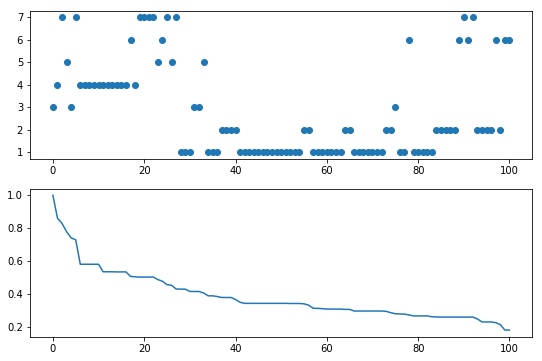

In [29]:
plot_relation_distribution(seasnake_rsl)

<h2> Type Four Test by Piranha </h2>

In [30]:
piranha_target = txtRDD.filter(lambda x: 'piranha' in x[0]).first()
piranha_targetdata = np.array([int(x) for i, x in enumerate(piranha_target) if i not in [0, 13, 17]])
piranha_targetdata

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0])

In [31]:
piranha_rsl = relation_score_list(piranha_targetdata)

In [32]:
print_rsl(piranha_rsl, 0.5)

id.       name	type	scores       	relation
 1.       bass	   4	31.2799566508	100.00%
 2.    catfish	   4	31.2799566508	100.00%
 3.       chub	   4	31.2799566508	100.00%
 4.    herring	   4	31.2799566508	100.00%
 5.    piranha	   4	31.2799566508	100.00%
 6.    dogfish	   4	29.5080268262	94.34%
 7.       pike	   4	29.5080268262	94.34%
 8.       tuna	   4	29.5080268262	94.34%
 9.    haddock	   4	29.4763852222	94.23%
10.   seahorse	   4	29.4763852222	94.23%
11.       sole	   4	29.4763852222	94.23%
12.   stingray	   4	28.4220053208	90.86%
13.       carp	   4	28.3286579495	90.56%
14.   seasnake	   3	22.540894268 	72.06%
15.    dolphin	   1	21.3033052766	68.11%
16.   porpoise	   1	21.3033052766	68.11%
17.       crab	   7	21.1195083387	67.52%
18.   crayfish	   7	21.1195083387	67.52%
19.    lobster	   7	21.1195083387	67.52%
20.   starfish	   7	21.1195083387	67.52%
21.       newt	   5	20.5292563706	65.63%
22.    seawasp	   7	20.0334868333	64.05%
23.    sealion	   1	19.5619259662	62.54%
24.    oc

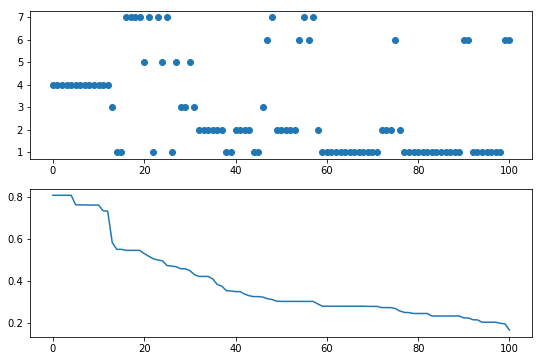

In [33]:
plot_relation_distribution(piranha_rsl)

<h2> Type One Test by Lion </h2>

In [34]:
lion_target = txtRDD.filter(lambda x: 'lion' in x[0]).first()
lion_targetdata = np.array([int(x) for i, x in enumerate(lion_target) if i not in [0, 13, 17]])
lion_targetdata

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [35]:
lion_rsl = relation_score_list(lion_targetdata)

In [36]:
print_rsl(lion_rsl, 0.5)

id.       name	type	scores       	relation
 1.       boar	   1	24.34638934  	100.00%
 2.    cheetah	   1	24.34638934  	100.00%
 3.    leopard	   1	24.34638934  	100.00%
 4.       lion	   1	24.34638934  	100.00%
 5.       lynx	   1	24.34638934  	100.00%
 6.   mongoose	   1	24.34638934  	100.00%
 7.    polecat	   1	24.34638934  	100.00%
 8.       puma	   1	24.34638934  	100.00%
 9.    raccoon	   1	24.34638934  	100.00%
10.       wolf	   1	24.34638934  	100.00%
11.   pussycat	   1	23.1986620672	95.29%
12.   aardvark	   1	22.9997226733	94.47%
13.       bear	   1	22.9997226733	94.47%
14.       mink	   1	22.7925431861	93.62%
15.   antelope	   1	22.5428179114	92.59%
16.    buffalo	   1	22.5428179114	92.59%
17.       deer	   1	22.5428179114	92.59%
18.   elephant	   1	22.5428179114	92.59%
19.    giraffe	   1	22.5428179114	92.59%
20.       oryx	   1	22.5428179114	92.59%
21.    wallaby	   1	22.5428179114	92.59%
22.       mole	   1	22.0509347945	90.57%
23.    opossum	   1	22.0509347945	90.57%
24. 

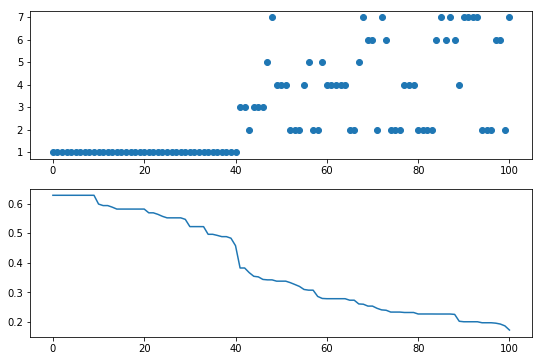

In [37]:
plot_relation_distribution(lion_rsl)

<h1> Cluster by Kmeans </h1>

In [38]:
dataset = sqlContext.createDataFrame(txtRDD.map(cleanDataToRow))

In [39]:
dataset.show(5)

+--------+-------+--------+--------+--------+-------+--------+----+--------+----+----+----+----+--------+--------+----+-------+--------+
|airborne|aquatic|backbone|breathes|category|catsize|domestic|eggs|feathers|fins|hair|legs|milk|    name|predator|tail|toothed|venomous|
+--------+-------+--------+--------+--------+-------+--------+----+--------+----+----+----+----+--------+--------+----+-------+--------+
|       0|      0|       1|       1|       1|      1|       0|   0|       0|   0|   1|   4|   1|aardvark|       1|   0|      1|       0|
|       0|      0|       1|       1|       1|      1|       0|   0|       0|   0|   1|   4|   1|antelope|       0|   1|      1|       0|
|       0|      1|       1|       0|       4|      0|       0|   1|       0|   1|   0|   0|   0|    bass|       1|   1|      1|       0|
|       0|      0|       1|       1|       1|      1|       0|   0|       0|   0|   1|   4|   1|    bear|       1|   0|      1|       0|
|       0|      0|       1|       1|     

In [40]:
cluster_num = 7
feature_cols = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone',
                'breathes', 'venomous', 'fins', 'eggs', 'tail', 'domestic', 'catsize']

# Combine selected columns to generate vector column
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features')

# Standard Scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                       withStd=True, withMean=True)

# KMeans
kmeans = KMeans(k=cluster_num, featuresCol="scaled_features", seed=1)

# pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
pipelineModel = pipeline.fit(dataset)

In [41]:
kmeans_model = pipelineModel.stages[2]
centers = kmeans_model.clusterCenters()
centers

[array([ 1.02985627, -0.49443795, -1.11625453,  1.20371316, -0.55551984,
        -0.35097328,  0.14122901,  0.74217826,  0.46337918,  0.50980485,
        -0.29183867, -0.11520021, -1.11625453,  0.23026068,  0.17467467,
         1.13253179]),
 array([-0.85676071, -0.49443795,  0.83953335, -0.82253733, -0.55551984,
         1.33704105,  0.27597787,  0.80575756,  0.46337918, -1.94211373,
        -0.00841842,  2.21184401,  0.83953335,  0.58586203, -0.15388343,
        -0.25676834]),
 array([-0.38325684, -0.49443795,  0.83953335, -0.82253733,  0.26959051,
        -0.00725995, -0.16790074, -1.22878029, -2.1366929 , -0.49980868,
         0.35836072, -0.4476351 ,  0.83953335, -1.68998664, -0.20766276,
        -0.75618996]),
 array([-0.85676071,  2.00247372,  0.83953335, -0.82253733,  1.78229281,
        -0.04799635, -0.44268274, -1.22878029,  0.46337918,  0.50980485,
        -0.29183867, -0.4476351 ,  0.83953335,  0.58586203,  0.21181602,
        -0.60666615]),
 array([-0.85676071, -0.49443795

In [42]:
predicted_df = pipelineModel.transform(dataset)
predicted_df.select(['name', 'hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
                     'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'eggs', 'tail', 'domestic',
                     'catsize', 'prediction']).show(5)

+--------+----+--------+----+----+--------+-------+--------+-------+--------+--------+--------+----+----+----+--------+-------+----------+
|    name|hair|feathers|eggs|milk|airborne|aquatic|predator|toothed|backbone|breathes|venomous|fins|eggs|tail|domestic|catsize|prediction|
+--------+----+--------+----+----+--------+-------+--------+-------+--------+--------+--------+----+----+----+--------+-------+----------+
|aardvark|   1|       0|   0|   1|       0|      0|       1|      1|       1|       1|       0|   0|   0|   0|       0|      1|         0|
|antelope|   1|       0|   0|   1|       0|      0|       0|      1|       1|       1|       0|   0|   0|   1|       0|      1|         0|
|    bass|   0|       0|   1|   0|       0|      1|       1|      1|       1|       0|       0|   1|   1|   1|       0|      0|         1|
|    bear|   1|       0|   0|   1|       0|      0|       1|      1|       1|       1|       0|   0|   0|   0|       0|      1|         0|
|    boar|   1|       0|   

In [43]:
X = predicted_df.rdd.map(lambda r: r.scaled_features.toArray()).collect()
y = predicted_df.rdd.map(lambda r: r.prediction).collect()

In [44]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((101, 16), (101,))

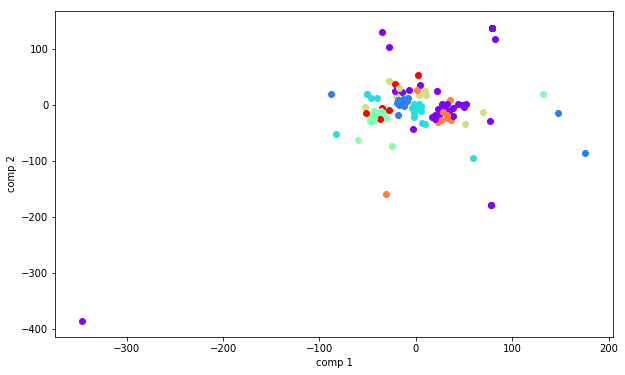

In [45]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, cluster_num))
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
points = tsne.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.xlabel('comp 1')
plt.ylabel('comp 2')
for p_c in zip(points,  colors[y]):
    plt.scatter(p_c[0][0], p_c[0][1], color=p_c[1])